In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN,Dropout
from keras.callbacks import History


import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM


import time #helper libraries
from sklearn.preprocessing import MinMaxScaler

from numpy import newaxis

import time

# For time stamps
from datetime import datetime
import yfinance as yf

In [2]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

In [3]:
stock_data = pd.read_csv('TCS.NS.csv')

In [4]:
stock_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
stock_data.dropna(inplace=True)

# Printing df
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,580.500000,592.974976,576.500000,589.299988,469.976013,2248542.0
1,2012-01-03,591.625000,604.950012,590.000000,598.799988,477.552429,2708884.0
2,2012-01-04,602.450012,602.500000,584.650024,586.500000,467.743195,2386770.0
3,2012-01-05,586.400024,592.500000,583.674988,586.000000,467.344330,2547312.0
4,2012-01-06,583.000000,594.174988,578.400024,584.700012,466.307648,2119728.0
...,...,...,...,...,...,...,...
2714,2022-12-26,3228.350098,3272.000000,3225.050049,3252.899902,3188.315186,870157.0
2715,2022-12-27,3269.199951,3273.800049,3231.500000,3259.500000,3194.784424,835883.0
2716,2022-12-28,3249.800049,3266.100098,3226.000000,3257.100098,3192.432129,910795.0
2717,2022-12-29,3231.100098,3271.500000,3228.000000,3268.750000,3203.850586,1037927.0


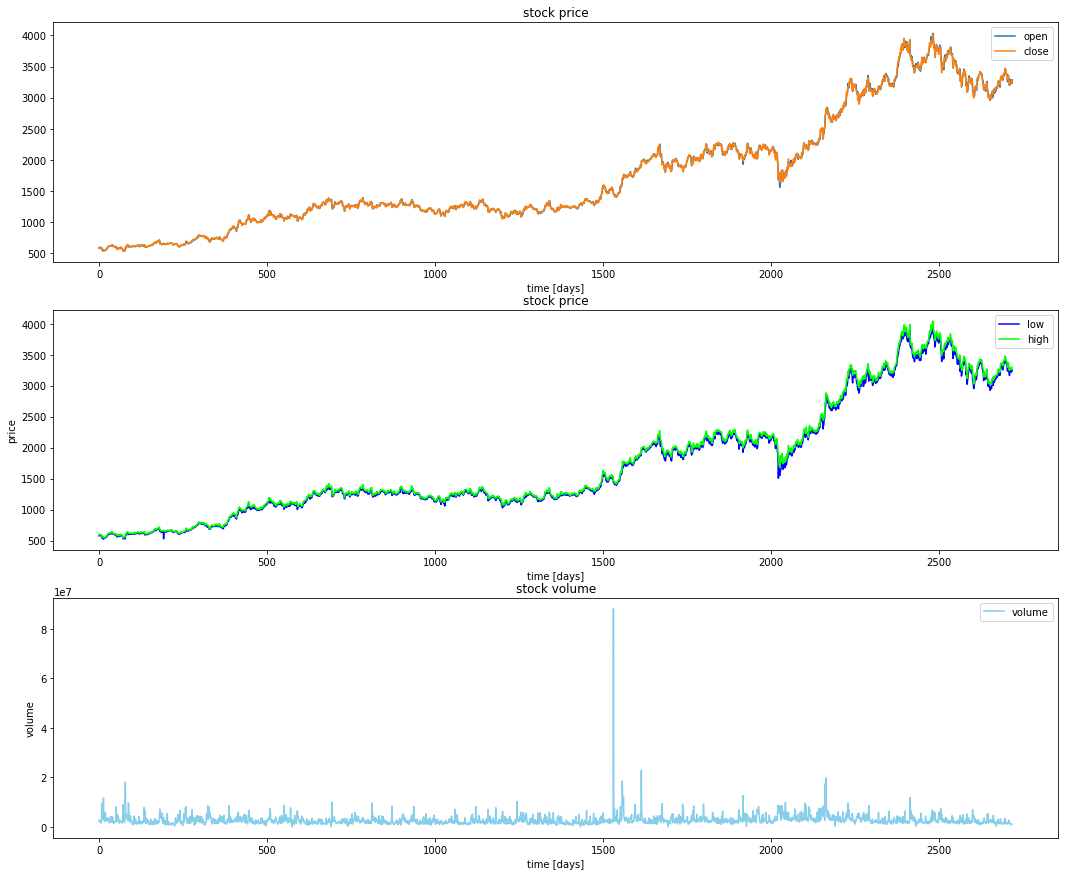

In [5]:
plt.figure(figsize=(18,15));
plt.subplot(3,1,1)
plt.plot(stock_data['Open'], label='open')
plt.plot(stock_data['Close'], label='close')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(stock_data['Low'], color='blue', label='low')
plt.plot(stock_data['High'], color='lime', label='high')
#plt.gca().invert_xaxis()
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(3,1,3)
plt.plot(stock_data['Volume'], color='skyblue', label='volume')
#plt.gca().invert_xaxis()
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [7]:
close_prices= stock_data.filter(['Close']) #creates a dataframe just with specified column( close )
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.8)

In [8]:
scaled_data=scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len,:]

In [9]:
window_size = 60
x_train=[]
y_train=[]
for i in range(window_size,len(train_data)):
  x_train.append(train_data[i-window_size:i,0])
  y_train.append(train_data[i,0])

In [10]:
x_train,y_train=np.array(x_train),np.array(y_train)


In [11]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [12]:
test_data = scaled_data[training_data_len - window_size: , :]
x_test=[]
y_test= values[training_data_len:]
for j in range(window_size,len(test_data)):
  x_test.append(test_data[j-window_size:j,0])

x_test=np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [13]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2111, 60, 1)
y_train.shape =  (2111,)
x_test.shape =  (542, 60, 1)
y_test.shape =  (542, 1)


In [14]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy'])
# Fitting to the training set
history=regressorGRU.fit(x_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


F:\Python 3.9.7\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


15/15 [==============================] - 6s 112ms/step - loss: 0.0498 - accuracy: 4.7371e-04
Epoch 2/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0239 - accuracy: 4.7371e-04
Epoch 3/50
15/15 [==============================] - 2s 108ms/step - loss: 0.0161 - accuracy: 4.7371e-04
Epoch 4/50
15/15 [==============================] - 2s 112ms/step - loss: 0.0118 - accuracy: 4.7371e-04
Epoch 5/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0080 - accuracy: 4.7371e-04
Epoch 6/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0046 - accuracy: 4.7371e-04
Epoch 7/50
15/15 [==============================] - 2s 111ms/step - loss: 0.0024 - accuracy: 4.7371e-04
Epoch 8/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0015 - accuracy: 4.7371e-04
Epoch 9/50
15/15 [==============================] - 2s 110ms/step - loss: 0.0012 - accuracy: 4.7371e-04
Epoch 10/50
15/15 [==============================] - 2s 110ms/step - loss: 

In [15]:
predictions = regressorGRU.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 13ms/step


In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = np.mean(predictions - y_test)**2
from sklearn.metrics import r2_score
#R2 = r2_score(y_test, predictions, multioutput='variance_weighted')
print('RMSE : ',rmse)
print('MSE : ',mse)
#print('R2 : ',R2)

RMSE :  74.94761831342252
MSE :  5617.145490854467


In [17]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, predictions)
print(mape)

0.02968563217288156


C:\Users\DELL\AppData\Local\Temp\ipykernel_3400\3648870739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions


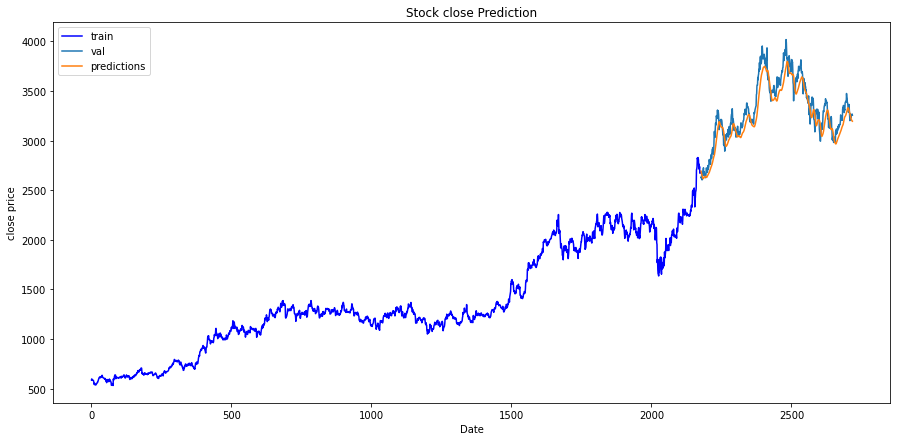

In [18]:
data1 = stock_data.filter(['Close'])
train= data1[:training_data_len]
validation = data1[training_data_len:]
validation['predictions'] = predictions

plt.figure(figsize=(15, 7))
plt.title('Stock close Prediction')
plt.xlabel('Date')
plt.ylabel('close price')
plt.plot(train, color='blue')
plt.plot(validation[['Close','predictions']])
plt.legend(['train','val','predictions'],loc='upper left')
plt.show()
     

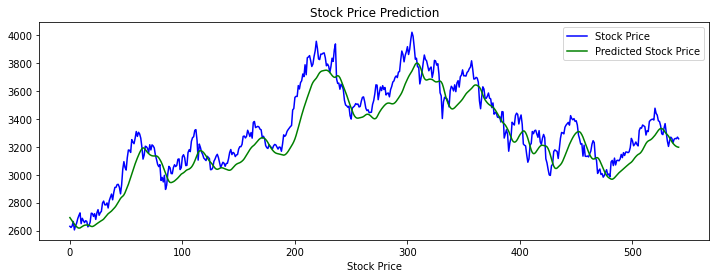

In [19]:
plt.figure(figsize=(12, 4))

real_stock_price = y_test[:]
plt.plot(real_stock_price, color='blue', label='Stock Price')
plt.plot(predictions, color='green', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel('Stock Price')
plt.legend()
plt.show()

In [20]:
#predicting the future values with help of the trained model

In [21]:
len(y_test)

542

In [22]:
len(x_test)

542

In [23]:
fut_inp = x_test[442:] #Taking previous 100 values as future input

In [24]:
fut_inp = fut_inp.reshape(1,-1)

In [25]:
tmp_inp = list(fut_inp)

In [26]:
fut_inp.shape

(1, 6000)

In [27]:
tmp_inp = tmp_inp[0].tolist()

In [28]:
# Predicting the next 2 months closing value
lst_output=[]
n_steps=6000
i=0
while(i<62):
    
    if(len(tmp_inp)>6000):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = regressorGRU.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = regressorGRU.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7640303373336792], [0.7632663249969482], [0.7619175910949707], [0.7600080966949463], [0.757710337638855], [0.7552013397216797], [0.7526070475578308], [0.7499991059303284], [0.7474102973937988], [0.7448517084121704], [0.7423239350318909], [0.7398244738578796], [0.7373506426811218], [0.7349004745483398], [0.7324725389480591], [0.7300660014152527], [0.7276804447174072], [0.7253157496452332], [0.7229712605476379], [0.7206466197967529], [0.7183418273925781], [0.7160565257072449], [0.7137901782989502], [0.7115427851676941], [0.709313690662384], [0.7071027159690857], [0.7049095034599304], [0.7027340531349182], [0.7005757093429565], [0.698434591293335], [0.6963100433349609], [0.6942020654678345], [0.6921101212501526], [0.6900343298912048], [0.687974214553833], [0.685929536819458], [0.6839000582695007], [0.6818856596946716], [0.6798860430717468], [0.6779009699821472], [0.6759301424026489], [0.673973560333252], [0.6720309257507324], [0.6701019406318665], [0.6681864857673645], [0.666284382343

In [29]:
a=np.array(lst_output)
b=scaler.inverse_transform(lst_output)
print(b)

[[3196.31781217]
 [3193.65368212]
 [3188.95061342]
 [3182.2921589 ]
 [3174.27981585]
 [3165.53087763]
 [3156.48451625]
 [3147.39055886]
 [3138.36331902]
 [3129.44145553]
 [3120.62704681]
 [3111.91136345]
 [3103.28505253]
 [3094.74125524]
 [3086.27498334]
 [3077.88332704]
 [3069.56483143]
 [3061.31908083]
 [3053.14378896]
 [3045.03770877]
 [3037.00084027]
 [3029.03193638]
 [3021.12912653]
 [3013.29241072]
 [3005.51950267]
 [2997.80977886]
 [2990.16199222]
 [2982.57614276]
 [2975.04994422]
 [2967.58381226]
 [2960.17546062]
 [2952.82488931]
 [2945.53022773]
 [2938.29189157]
 [2931.10821808]
 [2923.97837591]
 [2916.90153366]
 [2909.87727567]
 [2902.90456271]
 [2895.98256342]
 [2889.11023857]
 [2882.28758817]
 [2875.51357301]
 [2868.78715386]
 [2862.10791505]
 [2855.47523304]
 [2848.88806863]
 [2842.34642181]
 [2835.84904551]
 [2829.39593976]
 [2822.98544179]
 [2816.61775946]
 [2810.29247707]
 [2804.00834758]
 [2797.76537097]
 [2791.56271589]
 [2785.39934311]
 [2779.27587616]
 [2773.1904444

In [30]:
len(scaled_data)

2713

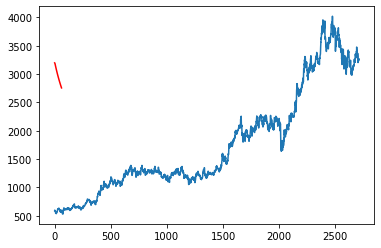

In [31]:
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(scaler.inverse_transform(lst_output), color='red') #the future predicted values with the previous values are plotted

In [32]:
ds_new = scaled_data.tolist()

In [33]:
len(ds_new)

2713

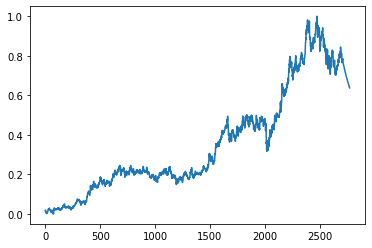

In [34]:
ds_new.extend(lst_output) #with the help of extend function we have the complete graph
plt.plot(ds_new)

In [35]:
final_graph = scaler.inverse_transform(ds_new).tolist()

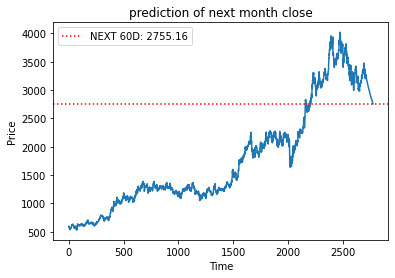

In [36]:
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("prediction of next month close")
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 60D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()